<a href="https://colab.research.google.com/github/shabansatti/Dynamic-Simulation-SMIB-Kundur/blob/main/Dynamic_Simulation_sm_ib_kundur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/hallvar-h/dynpssimpy

  Cloning https://github.com/hallvar-h/dynpssimpy to /tmp/pip-req-build-rzq7tq37
  Running command git clone --filter=blob:none --quiet https://github.com/hallvar-h/dynpssimpy /tmp/pip-req-build-rzq7tq37
  Resolved https://github.com/hallvar-h/dynpssimpy to commit 31f35a9fe26e137c6613bf8ea90d57e6b184b503
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dynpssimpy: filename=dynpssimpy-0.2.0-py3-none-any.whl size=52018 sha256=c8ea23a6184beb5fab4962f2e6ba3eda182dc5f8b94efbe716364bf8bb752657
  Stored in directory: /tmp/pip-ephem-wheel-cache-4scmghzy/wheels/a2/3c/3b/d3502fa307d2aad42e905c31d080ac19e3839af0be9fa90140
Successfully built dynpssimpy


In [2]:
from dynpssimpy import dynamic
import dynpssimpy.ps_models.sm_ib_kundur as PS
import dynpssimpy.dynamic as dyn
import dynpssimpy.solvers as solver
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import numpy as np

In [3]:
# Step-1: Loading the Power System Model
model=PS.load();

# Step-2: Instantiating the PowerSystemModel
smib=dyn.PowerSystemModel(model);

In [4]:
smib.setup_ready = False;
smib.setup();
ybus_lf = smib.build_y_bus_lf();
print("Load Flow Admittance Matrix: \n", ybus_lf)
print("Dimensions Admittance Matrix: \n", np.shape(ybus_lf))

Load Flow Admittance Matrix: 
 [[0.-1.53846154j 0.+1.53846154j]
 [0.+1.53846154j 0.-1.53846154j]]
Dimensions Admittance Matrix: 
 (2, 2)


In [5]:
from tabulate import tabulate
smib.power_flow();
print ("Power Flow Ready: \n", smib.power_flow_ready)
print ("Power Flow Solution")
print ("Voltage: ", np.absolute(smib.v0));
print ("Angle: ", np.angle(smib.v0))

Power Flow Ready: 
 True
Power Flow Solution
Voltage:  [1.    0.995]
Angle:  [0.63513303 0.        ]


In [6]:
smib.init_dyn_sim();
print ("Reduced Admittance Matrix: \n", smib.y_bus_red_full)
print ("Dimesions of Red Admittance Matrix: \n", np.shape(smib.y_bus_red_full))

Reduced Admittance Matrix: 
 [[0. -5.88628763j 0. +1.53846154j]
 [0. +1.53846154j 0.-45.01672241j]]
Dimesions of Red Admittance Matrix: 
 (2, 2)


In [7]:
time_step   =   0.001;
start_time  =   0;
end_time    =   5;
result_dict =   defaultdict(list)
smib_states =   smib.x_0;
fault       =   0;
gen_bus_idx = smib.gen['GEN'].bus_idx_red['terminal'][0]

print ("States Descriptor: \n", smib.state_desc);
print ("Initial States: \n", smib_states)
print ('No. of States: ', np.shape(smib_states))
print (gen_bus_idx);

States Descriptor: 
 [['GOV1/LeadLag' 'x']
 ['GOV1/TimeConstantLims' 'x']
 ['AVR1/LeadLag' 'x']
 ['AVR1/TimeConstantLims' 'x']
 ['G1' 'speed']
 ['G1' 'angle']
 ['G1' 'e_q_t']
 ['G1' 'e_d_t']
 ['G1' 'e_q_st']
 ['G1' 'e_d_st']
 ['IB' 'speed']
 ['IB' 'angle']
 ['IB' 'e_q_t']
 ['IB' 'e_d_t']
 ['IB' 'e_q_st']
 ['IB' 'e_d_st']]
Initial States: 
 [ 0.          0.90818182 -0.13572889  2.26214819  0.          1.43948845
  0.95356011  0.45433292  0.89289708  0.62624268  0.         -0.15555948
  0.99589148 -0.09848995  0.99288005 -0.13446019]
No. of States:  (16,)
0


In [8]:
t       = start_time;
states  = smib_states;

while t < end_time:

  sol = solver.ModifiedEulerDAE(smib.state_derivatives, smib.solve_algebraic, t, states, end_time, max_step = time_step);
  sol.step();
  states = sol.y;
  t      = sol.t;
  if (t>0.1 and t<0.15):
    smib.y_bus_red_mod [gen_bus_idx,gen_bus_idx]    = 1e10 * fault;
  else:
    smib.y_bus_red_mod [gen_bus_idx,gen_bus_idx]    = 0;

  result_dict['Global', 't'].append(sol.t)
  [result_dict[tuple(desc)].append(state) for desc, state in zip(smib.state_desc, states)]


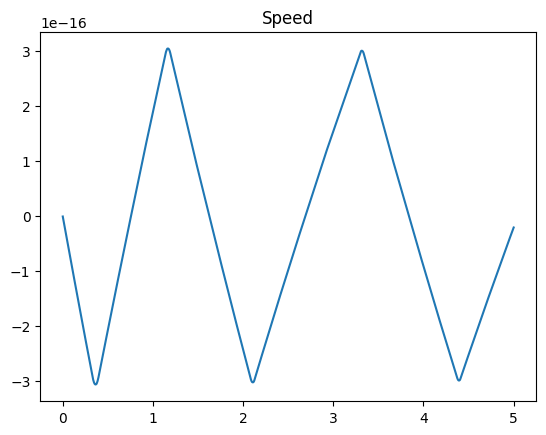

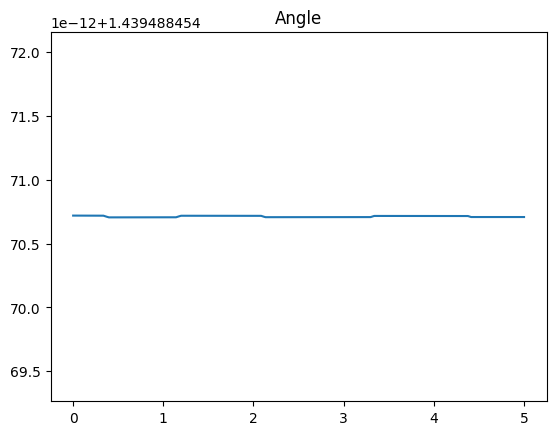

In [9]:
plt.figure()
state1 = 'speed';
state2 = 'angle';

plt.plot(result_dict[('Global', 't')], result_dict[('G1', state1)])
plt.title("Speed")
plt.show()
plt.plot(result_dict[('Global', 't')], result_dict[('G1', state2)])
plt.title("Angle")
plt.show()